In [1]:
import tensorflow as tf
import numpy as np
import input_data
import os
import shutil
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def imsave(path,images):
    return scipy.misc.imsave(path, images)

In [3]:
img_height = 28  
img_width = 28  
img_size = img_height * img_width  
  
to_train = True  
to_restore = False  
output_path = "output"  
  
max_epoch = 50 

h1_size = 150  
h2_size = 300  
z_size = 102  
batch_size = 256  

In [4]:
def build_generator(z_prior):  
    w1 = tf.Variable(tf.truncated_normal([z_size, h1_size], stddev=0.1), name="g_w1", dtype=tf.float32)  
    b1 = tf.Variable(tf.zeros([h1_size]), name="g_b1", dtype=tf.float32)  
    h1 = tf.nn.relu(tf.matmul(z_prior, w1) + b1)  
    w2 = tf.Variable(tf.truncated_normal([h1_size, h2_size], stddev=0.1), name="g_w2", dtype=tf.float32)  
    b2 = tf.Variable(tf.zeros([h2_size]), name="g_b2", dtype=tf.float32)  
    h2 = tf.nn.relu(tf.matmul(h1, w2) + b2)  
    w3 = tf.Variable(tf.truncated_normal([h2_size, img_size], stddev=0.1), name="g_w3", dtype=tf.float32)  
    b3 = tf.Variable(tf.zeros([img_size]), name="g_b3", dtype=tf.float32)  
    h3 = tf.matmul(h2, w3) + b3  
    x_generate = tf.nn.tanh(h3)  
    g_params = [w1, b1, w2, b2, w3, b3]  
    return x_generate, g_params  


In [5]:
def build_discriminator(x_data, x_generated, keep_prob):  
    x_in = tf.concat([x_data, x_generated], 0)  
    w1 = tf.Variable(tf.truncated_normal([img_size, h2_size], stddev=0.1), name="d_w1", dtype=tf.float32)  
    b1 = tf.Variable(tf.zeros([h2_size]), name="d_b1", dtype=tf.float32)  
    h1 = tf.nn.dropout(tf.nn.relu(tf.matmul(x_in, w1) + b1), keep_prob)
    
    w2 = tf.Variable(tf.truncated_normal([h2_size, h1_size], stddev=0.1), name="d_w2", dtype=tf.float32)  
    b2 = tf.Variable(tf.zeros([h1_size]), name="d_b2", dtype=tf.float32)  
    h2 = tf.nn.dropout(tf.nn.relu(tf.matmul(h1, w2) + b2), keep_prob)  
    
    w3 = tf.Variable(tf.truncated_normal([h1_size, 1], stddev=0.1), name="d_w3", dtype=tf.float32)  
    b3 = tf.Variable(tf.zeros([1]), name="d_b3", dtype=tf.float32)  
    h3 = tf.matmul(h2, w3) + b3  
    
    y_data = tf.nn.sigmoid(tf.slice(h3, [0, 0], [batch_size, -1], name=None))  
    y_generated = tf.nn.sigmoid(tf.slice(h3, [batch_size, 0], [-1, -1], name=None))  
    d_params = [w1, b1, w2, b2, w3, b3]  
    
    
    wc = tf.Variable(tf.truncated_normal([h1_size, 128], stddev=0.1), name="d_wc", dtype=tf.float32)  
    bc = tf.Variable(tf.zeros([128]), name="d_bc", dtype=tf.float32)  
    hc = tf.nn.sigmoid(tf.matmul(h2, wc) + bc)
    
    wc2 = tf.Variable(tf.truncated_normal([128, 2], stddev=0.1), name="d_wc2", dtype=tf.float32)  
    bc2 = tf.Variable(tf.zeros([2]), name="d_bc2", dtype=tf.float32)  
    hc2 = tf.nn.tanh(tf.matmul(hc, wc2) + bc2)
    hc2_y=tf.slice(hc2,[batch_size, 0], [-1, -1], name=None)
    
    wc3 = tf.Variable(tf.truncated_normal([128, 10], stddev=0.1), name="d_wc2", dtype=tf.float32)  
    bc3 = tf.Variable(tf.zeros([10]), name="d_bc2", dtype=tf.float32)  
    hc3 = tf.nn.softmax(tf.matmul(hc, wc3) + bc3)
    hc3_y=tf.slice(hc3,[batch_size, 0], [-1, -1], name=None)
    
    return y_data, y_generated, d_params ,hc2_y,hc3_y,[wc,bc,wc2,bc2,wc3,bc3]

In [6]:
def train():  
    mnist = input_data.read_data_sets('MNIST_data', one_hot=True)  
  
    x_data = tf.placeholder(tf.float32, [batch_size, img_size], name="x_data")  
    z_prior = tf.placeholder(tf.float32, [batch_size, z_size-12], name="z_prior")  
    z_prior_i = tf.placeholder(tf.int32, [batch_size, 1], name="z_prior_i")
    z_prior_c = tf.placeholder(tf.float32, [batch_size, 2], name="z_prior_c") 
    oh_list = []
    oh_list.append(z_prior)
    
    one_hot=tf.squeeze(tf.one_hot(z_prior_i,10))
    
    oh_list.append(one_hot)  #映射到10个节点
    oh_list.append(z_prior_c)
    z_prior_n = tf.concat(oh_list,1)
    
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")  
    global_step = tf.Variable(0, name="global_step", trainable=False)  
  
    x_generated, g_params = build_generator(z_prior_n)  
    y_data, y_generated, d_params,hc2,hc3,q_p = build_discriminator(x_data, x_generated, keep_prob)  
  
    d_loss = - (tf.log(y_data) + tf.log(1 - y_generated))  
    g_loss = - tf.log(y_generated)  
    q_loss = tf.reduce_mean( -tf.reduce_sum(one_hot*tf.log(hc3),reduction_indices=1)+ tf.reduce_sum(0.5 * tf.square(hc2 - z_prior_c),reduction_indices=1))
    #q_loss = tf.reduce_mean(-tf.reduce_sum(one_hot*tf.log(hc3),reduction_indices=1))
    
    optimizer_d = tf.train.AdamOptimizer(0.0001)
    optimizer_g = tf.train.AdamOptimizer(0.0005)
    optimizer_q = tf.train.AdamOptimizer(0.0001)
    d_trainer = optimizer_d.minimize(d_loss, var_list=d_params)
    g_trainer = optimizer_g.minimize(g_loss, var_list=g_params)  
    q_trainer = optimizer_q.minimize(q_loss, var_list=[d_params,g_params,q_p])  
    
    #trainerD = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
    #trainerG = tf.train.AdamOptimizer(learning_rate=0.002,beta1=0.5)
    #trainerQ = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
    #d_grads = trainerD.compute_gradients(d_loss,var_list=d_params) #Only update the weights for the discriminator network.
    #g_grads = trainerG.compute_gradients(g_loss,var_list=g_params) #Only update the weights for the generator network.
    #q_grads = trainerG.compute_gradients(q_loss,var_list=[d_params,g_params,q_p]) 
    #d_trainer = trainerD.apply_gradients(d_grads)
    #g_trainer = trainerG.apply_gradients(g_grads)
    #q_trainer = trainerQ.apply_gradients(q_grads)
    
    
  
    init = tf.global_variables_initializer()  
  
    saver = tf.train.Saver()  
  
    sess = tf.Session()  
  
    sess.run(init)  
  
    if to_restore:  
        chkpt_fname = tf.train.latest_checkpoint(output_path)  
        saver.restore(sess, chkpt_fname)  
    else:  
        if os.path.exists(output_path):  
            shutil.rmtree(output_path)  
        os.mkdir(output_path)  
  
    
  
    for i in range(sess.run(global_step), max_epoch):  
        for j in range(60000 / batch_size):  
            x_value, _ = mnist.train.next_batch(batch_size)  
            x_value = 2 * x_value.astype(np.float32) - 1  
            z_value = np.random.normal(0, 1, size=(batch_size, z_size-12)).astype(np.float32) 
            lcat = np.random.randint(0,10,[batch_size,1]) 
            lcont = np.random.uniform(-1,1,[batch_size,2]) #
            #z_value_i=np.column_stack((z_value,lcont))
            
            _,d_l=sess.run([d_trainer,d_loss],  
                     feed_dict={x_data: x_value, z_prior: z_value,z_prior_i:lcat,z_prior_c:lcont, keep_prob: np.sum(0.7).astype(np.float32)})  
            #if j % 1 == 0:  
            _,g_l=sess.run([g_trainer,g_loss],  
                         feed_dict={x_data: x_value, z_prior: z_value,z_prior_i:lcat,z_prior_c:lcont, keep_prob: np.sum(0.7).astype(np.float32)}) 
            #for t in range(2):
            _,q_l,one_hot_v,hc3_v,z_prior_c_v,hc2_v=sess.run([q_trainer,q_loss,one_hot,hc3,z_prior_c,hc2],  
                         feed_dict={x_data: x_value, z_prior: z_value,z_prior_i:lcat,z_prior_c:lcont, keep_prob: np.sum(0.7).astype(np.float32)})
        #print np.mean(g_l)
        if(i%10==0) :
                print "epoch:%s, d_loss:%f,g_loss:%f,q_loss:%f" % (i, np.mean(d_l),np.mean(g_l),np.mean(q_l))  
        if (i%50==0):
            z_sample_val = np.random.normal(0, 1, size=(batch_size, z_size-12)).astype(np.float32)  
            lcat_1=np.reshape(np.array([e for e in range(8) for _ in range(8)]),[64,1])
            lcat_1=np.row_stack((lcat_1,np.zeros([batch_size-64,1])))
            lcont_1=np.reshape(np.array([[(e/3.5 - 1.)*1] for e in range(8) for _ in range(8)]),[64,1])
            lcont_1=np.row_stack((lcont_1,np.zeros([batch_size-64,1])))
            lcont_2=np.zeros_like(lcont_1);
            z_sample_val_i = np.hstack([lcont_1,lcont_2])
            
            x_gen_val = sess.run(x_generated, feed_dict={z_prior: z_sample_val,z_prior_i:lcat_1,z_prior_c:z_sample_val_i})  
            show_result(x_gen_val, os.path.join(output_path, "sample%s.jpg" % i))  
            #z_random_sample_val = np.random.normal(0, 1, size=(batch_size, z_size)).astype(np.float32)  
            #x_gen_val = sess.run(x_generated, feed_dict={z_prior: z_random_sample_val})  
            #show_result(x_gen_val, os.path.join(output_path, "random_sample%s.jpg" % i))  
            sess.run(tf.assign(global_step, i + 1))  
            saver.save(sess, os.path.join(output_path, "model"), global_step=global_step)  
    return one_hot_v,hc3_v,z_prior_c_v,hc2_v

In [7]:
def show_result(batch_res, fname, grid_size=(8, 8), grid_pad=5):  
    batch_res = 0.5 * batch_res.reshape((batch_res.shape[0], img_height, img_width)) + 0.5  
    img_h, img_w = batch_res.shape[1], batch_res.shape[2]  
    grid_h = img_h * grid_size[0] + grid_pad * (grid_size[0] - 1)  
    grid_w = img_w * grid_size[1] + grid_pad * (grid_size[1] - 1)  
    img_grid = np.zeros((grid_h, grid_w), dtype=np.uint8)  
    for i, res in enumerate(batch_res):  
        if i >= grid_size[0] * grid_size[1]:  
            break  
        img = (res) * 255  
        img = img.astype(np.uint8)  
        row = (i // grid_size[0]) * (img_h + grid_pad)  
        col = (i % grid_size[1]) * (img_w + grid_pad)  
        img_grid[row:row + img_h, col:col + img_w] = img  
    imsave(fname, img_grid)

In [ ]:
max_epoch = 500
one_hot_v,hc3_v,z_prior_c_v,hc2_v=train()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


[ 0.3839829  -0.83459145]
[-0.02519144  0.00999973]


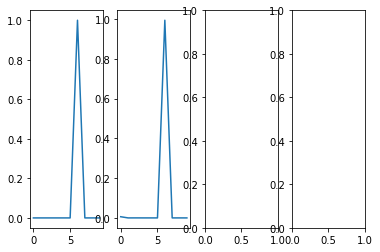

In [11]:
one_hot_v[1,:].shape
plt.subplot(1,4,1)
plt.plot(one_hot_v[2,:])
plt.subplot(1,4,2)
plt.plot(hc3_v[2,:])
plt.subplot(1,4,3)
print(z_prior_c_v[2,:])
plt.subplot(1,4,4)
print(hc2_v[2,:])

In [28]:
max_epoch = 50
import cProfile
cProfile.run('train()', 'log_file.pyprof')
os.system('gprof2dot -f pstats log_file.pyprof | dot -Tpng -o output.png')
os.system('jupyter nbconvert GAN_Tutor.ipynb --to python')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Use `tf.global_variables_initializer` instead.
epoch:0, d_loss:0.283209,g_loss:3.754898
epoch:10, d_loss:0.606401,g_loss:2.242795
epoch:20, d_loss:0.795846,g_loss:1.983448
epoch:30, d_loss:0.760122,g_loss:1.811489
epoch:40, d_loss:0.999529,g_loss:1.440125


0

In [ ]:
sess = tf.Session()  
print(sess.run(-tf.log(tf.to_float(0.42))))
print(sess.run(-tf.log(0.45)-tf.log(1-0.42)))
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)  
x_value, _ = mnist.train.next_batch(batch_size)  
x_value.shape

In [40]:
z_value = np.random.normal(0, 1, size=(batch_size, z_size)).astype(np.float32)  
#z_value_10 = np.random.normal(0, 1, size=(batch_size, 10)).astype(np.float32) 
#latent_cat_in = tf.placeholder(shape=[None,10],dtype=tf.int32)
#lcat = np.random.randint(0,10,[batch_size,10]) #Generate random c batch
lcont = np.random.uniform(-1,1,[batch_size,2]) #
z_value_i=np.column_stack((z_value,lcont))
np.reshape(np.array([[(e/1.5 - 1.)*1] for e in range(4) for _ in range(8)]),[8,8]).T

array([[-1.        , -0.33333333,  0.33333333,  1.        ],
       [-1.        , -0.33333333,  0.33333333,  1.        ],
       [-1.        , -0.33333333,  0.33333333,  1.        ],
       [-1.        , -0.33333333,  0.33333333,  1.        ]])

In [25]:
lcont_1=np.reshape(np.array([[(e/3.5 - 1.)*1] for e in range(8) for _ in range(8)]),[64,1]).T
print(lcont_1)

[[-1.         -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -0.71428571 -0.71428571 -0.71428571 -0.71428571 -0.71428571
  -0.71428571 -0.71428571 -0.71428571 -0.42857143 -0.42857143 -0.42857143
  -0.42857143 -0.42857143 -0.42857143 -0.42857143 -0.42857143 -0.14285714
  -0.14285714 -0.14285714 -0.14285714 -0.14285714 -0.14285714 -0.14285714
  -0.14285714  0.14285714  0.14285714  0.14285714  0.14285714  0.14285714
   0.14285714  0.14285714  0.14285714  0.42857143  0.42857143  0.42857143
   0.42857143  0.42857143  0.42857143  0.42857143  0.42857143  0.71428571
   0.71428571  0.71428571  0.71428571  0.71428571  0.71428571  0.71428571
   0.71428571  1.          1.          1.          1.          1.          1.
   1.          1.        ]]
